from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Dropbox_saiki/kato/Shell model")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import math
import cmath
from numba import njit, f8,i8,c16
import numba
import matplotlib.animation as animation
from IPython.display import HTML
import copy

import sys
sys.path.append('../../lb')
import RungeKutta_acceralated

In [2]:
#パラメーター
nu = 0.001

f = (1 + 1j) * 5 * 0.001

Dimention = 14 #uの次元数
q = 2
k_0 = 2 ** (-4)
k_n = np.zeros((Dimention+4,1))
k_n[2:-2,0] = [k_0 * q ** (i+1) for i in range(Dimention)]
#print(k_n)

c_n_1 = copy.deepcopy(k_n)[2:-2, 0:]
c_n_1[-2:, 0:] = np.zeros((2,1))
#print(c_n_1)

beta = 0.5
c_n_2 = copy.deepcopy(k_n)[1:-3, 0:] * -beta
c_n_2[-1, 0] = np.zeros((1, 1))
#print(c_n_2)

c_n_3 = copy.deepcopy(k_n)[:-4, 0:] * (beta - 1)
#print(c_n_3)

#parameter = [nu,f,k_n,c_n_1,c_n_2,c_n_3]
parameter = {
    'nu' : nu,
    'f' : f,
    'k_n' : k_n,
    'c_n_1' : c_n_1,
    'c_n_2' : c_n_2,
    'c_n_3' : c_n_3
}
#print(parameter)
#print(k_n)

In [3]:
runge_para = {
    'start' :  np.array([
        [0.4350E+00 + 0.5008E+00j],
        [0.1259E+00 + 0.2437E+00j],
        [-0.8312E-01 + -0.4802E-01j],
        [0.5164E-01 + -0.1599E+00j],
        [-0.1899E+00 + -0.3602E-01j],
        [0.4093E-03 + 0.8506E-01j],
        [0.9539E-01 + 0.3215E-01j],
        [-0.5834E-01 + 0.4433E-01j],
        [-0.8790E-02 + 0.2502E-01j],
        [0.3385E-02 + 0.1148E-02j],
        [-0.7072E-04 + 0.5598E-04j],
        [-0.5238E-07 + 0.1467E-06j],
        [0.1E-07 + 0.1E-06j],
        [0.1E-07 + 0.1E-06j]
    ]),
    'step' : 0.01,
    'period' : (0,50000),
    'nu' : nu,
    'f' : f,
    'k_n' : k_n,
    'c_n_1' : c_n_1,
    'c_n_2' : c_n_2,
    'c_n_3' : c_n_3
}

In [4]:
#c4が極大値を取る時のc5をndarrayで返す関数
@njit(f8[:](c16[:,:],i8,i8,f8[:]),cache=True)
def loc_max_7(arr,step_number,kaishi,z_list):
    for j in range(len(arr[0,-kaishi:]) - 3):
        #7点とって極大判定
        if (abs(arr[3,j-kaishi+1]) - abs(arr[3,j-kaishi]) > 0
        and abs(arr[3,j-kaishi+2]) - abs(arr[3,j-kaishi+1]) > 0
        and abs(arr[3,j-kaishi+3]) - abs(arr[3,j-kaishi+2]) > 0
        and abs(arr[3,j-kaishi+4]) - abs(arr[3,j-kaishi+3]) < 0
        and abs(arr[3,j-kaishi+5]) - abs(arr[3,j-kaishi+4]) < 0
        and abs(arr[3,j-kaishi+6]) - abs(arr[3,j-kaishi+5]) < 0):
            z_list = np.append(z_list,abs(arr[4,j-kaishi+3]))
    return z_list

100%|█████████████████████████████████████████| 200/200 [36:41<00:00, 11.01s/it]


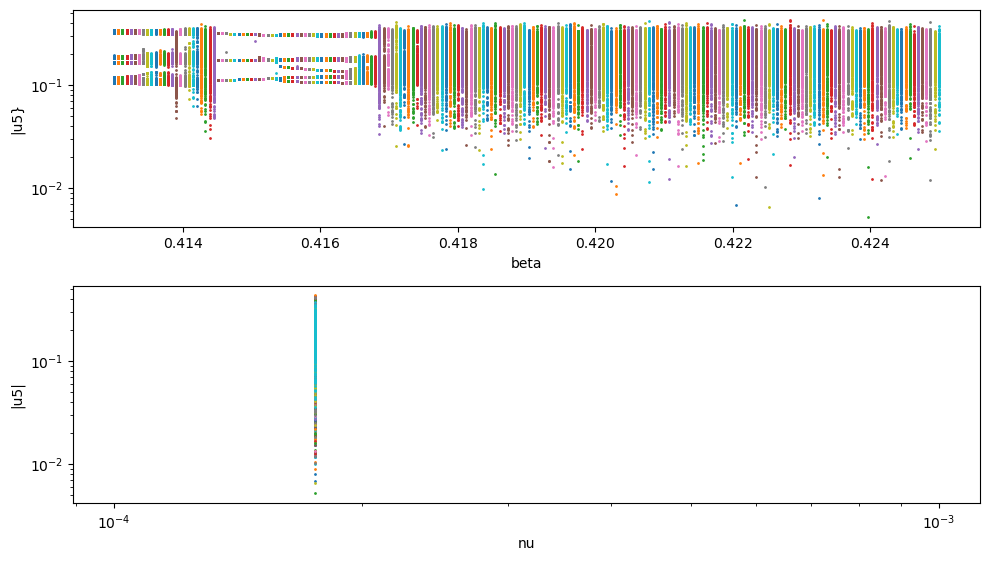

<Figure size 6400x4800 with 0 Axes>

In [5]:
beta_begin = 0.413 #パラメータ開始
beta_end = 0.425 #パラメータ終わり

nu_begin = 0.000175
nu_end = 0.000175

param_step = 200 #パラメータ何回刻む
latter = 5 #後半何分の1をプロットするか

beta_param = np.linspace(beta_begin,beta_end,param_step) #betaパラメータndarray作成
nu_param = np.linspace(nu_begin,nu_end,param_step) #log 10
# nu_param=[math.pow(10,i) for i in nu_param] #nuパラメータndarray作成
step_number = int((runge_para["period"][1] - runge_para["period"][0]) // runge_para["step"]) + 1
kaishi = step_number // latter


#インスタンス化
model = RungeKutta_acceralated.RungeKutta()

#プロットの設定
fig = plt.figure(figsize=(10,15))

spec = gridspec.GridSpec(ncols=1, nrows=3,
                         height_ratios=[4, 1, 1])

# ax1 = fig.add_subplot(spec[0],projection='3d')
# ax1.set_xlabel("beta")
# ax1.set_ylabel("nu(log10)")
# ax1.set_zlabel("|u5|(log10)")

ax2 = fig.add_subplot(spec[1])
ax2.set_xlabel("beta")
ax2.set_ylabel("|u5}")
ax2.set_yscale("log")

ax3 = fig.add_subplot(spec[2])
ax3.set_xlabel("nu")
ax3.set_ylabel("|u5|")
ax3.set_xscale("log")
ax3.set_yscale("log")

nu_fig = plt.figure(dpi=1000)



for i in tqdm(range(param_step)):
    #nu更新
    runge_para["nu"] = nu_param[i]
    
    #betaの値に従いc_n_2,c_n_3を更新
    #c_n_2
    runge_para["c_n_2"] = runge_para["k_n"][1:-3, 0:] * -beta_param[i]
    runge_para["c_n_2"][-1, 0:] = np.zeros((1, 1))

    #c_n_3
    runge_para["c_n_3"] = runge_para["k_n"][:-4, 0:] * (beta_param[i] - 1)


    model.get_arr(**runge_para)

    #次のパラメータの初期値を今回の最後の値に変更
    runge_para["start"] = model.arr[:-1,-1:]

    z_list=np.array([],dtype=np.float64)#u4極大値の時のu5を入れる空のリスト

    z_list = loc_max_7(model.arr,step_number,kaishi,z_list)


#     #3dプロット
#     z_list_log = np.log10(z_list)
#     ax1.scatter([beta_param[i]]*len(z_list),[log_range[i]]*len(z_list),z_list_log, s=1)

    #2dプロット
    ax2.scatter([beta_param[i]]*len(z_list),z_list,s=1)

    ax3.scatter([nu_param[i]]*len(z_list),z_list,s=1)

fig.tight_layout()
fig.savefig(fname=f"../bif_image_for_each_beta_and_nu/nu({nu_param[0]},{nu_param[-1]})_beta({beta_param[0]},{beta_param[-1]})_{runge_para['step']}_{runge_para['period']}_{param_step}cut_{Dimention}dim_latter{round(kaishi/step_number,2)}.png")


In [12]:
beta=0.447
print((nu_begin-nu_end)/(beta_begin-beta_end)*beta+nu_begin-(nu_begin-nu_end)/(beta_begin-beta_end)*beta_begin)

0.0001406790000000001
